# Project : CutMix 또는 Mixup 비교실험하기
---
Augmentation을 텐서플로우 모델 학습에서 어떻게 적용할 수 있는지 공부합니다. 
Augmentation도 입력 이미지의 데이터를 변경해주는 과정이므로 일반적인 이미지 데이터 전처리방법과 활용방법이 동일합니다.


텐서플로우 API로 바로 사용할 수 있는 방법들은 다음과 같습니다. 
* random_brightness()
* random_contrast()
* random_crop()
* random_flip_left_right()
* random_flip_up_down()
* random_hue()
* random_jpeg_quality()
* random_saturation()

이 노트북에서는 CutMIx와 Mixup으로 augmentation을 진행해봅니다.CutMix는 네이버 클로바(CLOVA)에서 발표한 CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법입니다. 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.

아래 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타냅니다. Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식입니다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다.


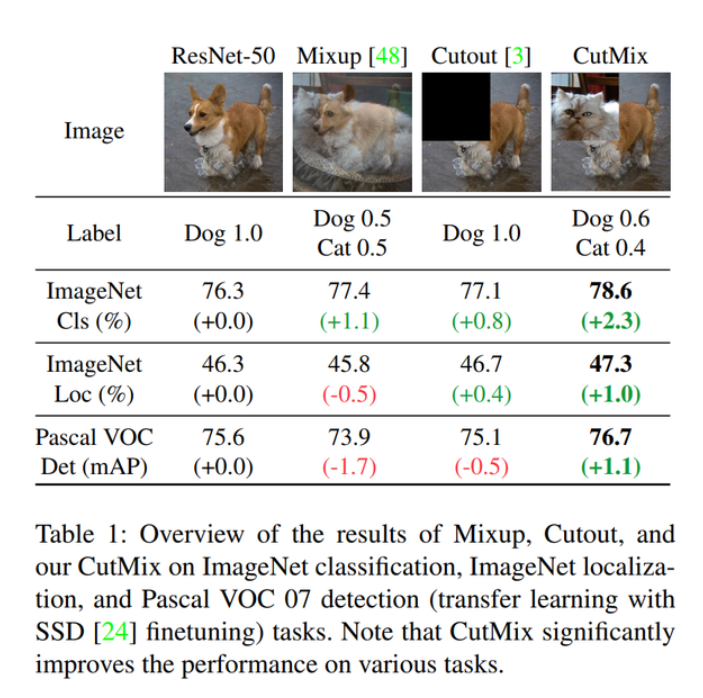


In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)


* stanford_dogs 데이터셋을 사용합니다. 120개의 견종의 이미지가 포함되어 있으며, 총 20580장의 이미지에서 12,000장은 train set, 8580장은 test set 입니다. 

In [5]:
num_classes = ds_info.features['label'].num_classes
print('class 개수 : ', num_classes)

class 개수 :  120


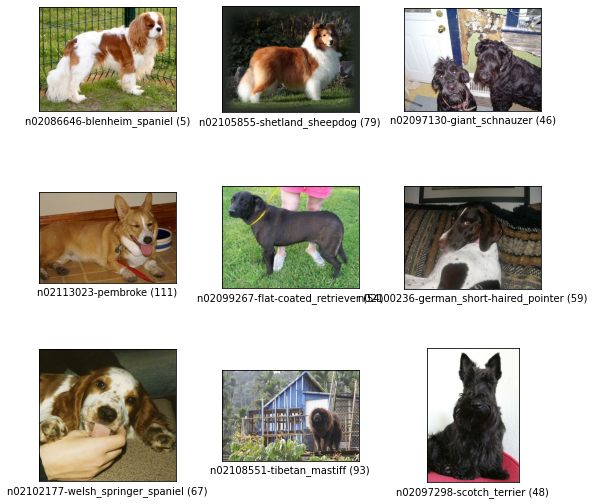

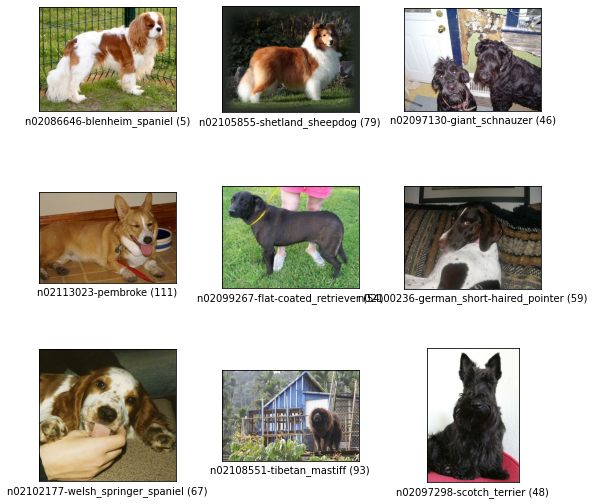

In [6]:
tfds.show_examples(ds_train, ds_info)

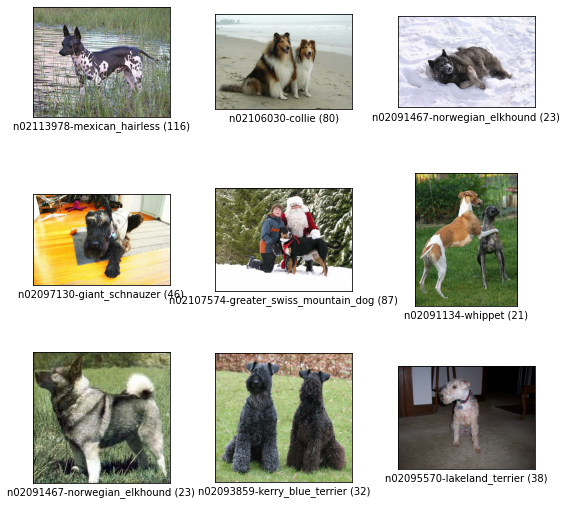

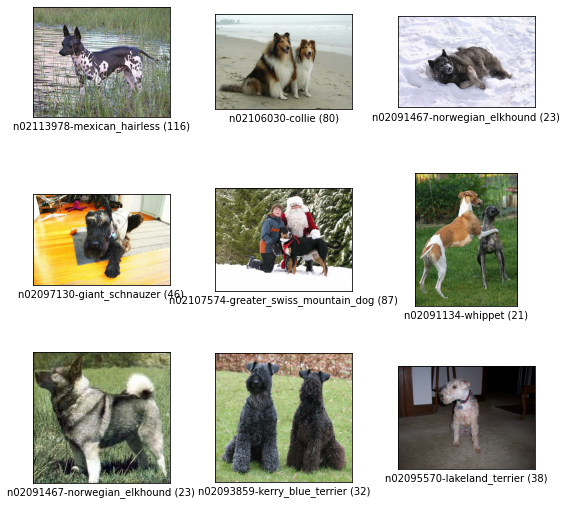

In [7]:
tfds.show_examples(ds_test, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기
---
데이터셋에 CutMix or Mixup augmentation을 적용해 줍니다.

! batch() 함수 뒤에 Cutmix가 오도록 해야합니다. Cutmix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬한 후 CutMix가 적용되어야 합니다. 


In [8]:
# 정규화 및 이미지 크기 변경하는 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])          
    image = tf.cast(image, tf.float32) / 255.           # 0~1 사이의 float32로 정규화
    return image, label

# label 원-핫 인코딩하는 함수
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label


# 좌우 대칭 및 밝기 변경하는 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label


# 데이터셋에 augmentation 적용하는 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 위에서 만든 normalize 함수를 병렬로 map 하기
    ds = ds.map(
        normalize_and_resize_img,   # 기본적인 전처리 함수 적용
        num_parallel_calls=2        # 병렬처리할 때 가용할 CPU 코어 개수
    )
    # apply base augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    # split dataset into batches of batch_size    
    ds = ds.batch(batch_size)
    
    
    if not is_test and with_cutmix:      # apply CutMix augmentation
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:     # apply MixUP augmentation
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:                                # apply one-hot encoding
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [9]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True
                                        )

### Augmentation을 하지 않은 기본 train셋, test셋

In [10]:
# 데이터셋에서 불러온 데이터 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어
# augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다. 


ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_test_no_aug = apply_normalize_on_dataset(ds_test, is_test=True)

### Base Augmentation만 적용한 train셋, test셋

In [11]:
ds_train_base_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test_base_aug = apply_normalize_on_dataset(ds_test, with_aug=True, is_test=True)

### CutMix Augmentation
* CutMix는 네이버 클로바가 제안한 방법입니다. 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다. 
* Mixup은 특정비율로 픽셀별 값을 섞는 방식
* Cutout은 이미지를 잘라내는 방식
* CutMix는 Mixup과 비슷하지만 일정영역을 잘라서 붙여주는 방법입니다. 

#### 1) 이미지 섞기
---
가장 먼저 이미지 를 섞어줍니다. 배치 내의 이미지를 두개 골라서 섞는데, 이때 이미지에서 잘라서 섞어주는 영역을 Bounding Box라고 합니다. 두개의 이미지 a와 b가 있다고 합시다. 첫번째 이미지 a를 바탕 이미지로 하고, 삽입할 두번째 이미지 b가 있을 때 a에 삽입될 영역의 바운딩 박스위 위치를 결정하는 함수를 먼저 구현합니다. 

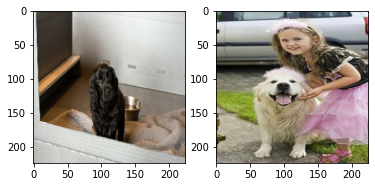

In [12]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [13]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(54, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(144, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


* 바탕이미지 a에서 바운딩 박스 바깥영억, 이미지 b에서 바운딩박스 안쪽 영역을 가져와서 합치는 함수를 구현합니다. 

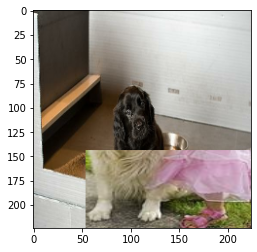

In [14]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 2) 라벨섞기
---
CutMix에서는 면적에 비례하여 라벨을 섞습니다. 섞인 이미지 2가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현합니다. 

In [15]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.7289541 ,
       0.        , 0.27104592, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치단위의 cutmix()함수를 구현합니다. 

In [16]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels



###  CutMix Augmentation 만 적용한  train셋, test셋 생성 

In [17]:
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_test_cutmix_aug = apply_normalize_on_dataset(ds_test, with_cutmix=True, is_test=True)

### Mixup Augmentation

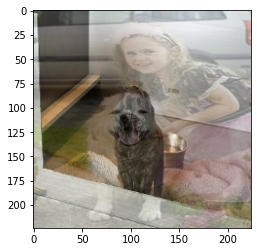

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.67141426 0.         0.32858574 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [18]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [19]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels



### Mixup Augmentation만 적용한 train셋, test셋

In [20]:
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test_mixup_aug = apply_normalize_on_dataset(ds_test, with_mixup=True, is_test=True)

## 2. 모델 만들기(비교실험)
---
모델은 ResNet-50을 사용합니다. 비교 실험을 위해 모델을 여러개를 만듭니다.

우리가 비교해야 할 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능입니다. 


텐서플로우 케라스의 ResNet-50 중 imagenet 데이터셋으로 훈련된 모델을 불러옵니다. include_top은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor)부분만 불러와 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 ImageNet과 사용할 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가할 fully connected layer의 구조가 다르기 때문입니다. 

### Augmentation을 적용하지 않은 데이터셋으로 학습시킬 ResNet50

In [21]:
num_classes = ds_info.features["label"].num_classes
# Augmentation을 적용하지 않은 데이터셋으로 학습시킬 ResNet
resnet50_no_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])


### Base Augmentation만 적용한 데이터셋으로 학습시킬 모델

In [22]:
# Base Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만듭니다. 

resnet50_base_aug = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top=False,
                                                                           weights='imagenet',
                                                                           input_shape=(224,224,3),
                                                                           pooling='avg'),
                                        keras.layers.Dense(num_classes, activation='softmax')
                                       ])

### CutMix Augmentation을 적용한 데이터셋으로 학습시킬 모델

In [23]:
resnet50_cutmix_aug = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top=False,
                                                                                  weights='imagenet',
                                                                                  input_shape=(224,224,3),
                                                                                  pooling='avg'),
                                              keras.layers.Dense(num_classes, activation='softmax')
                                              ])

### Mixup Augmentation을 적용한 데이터셋으로 학습시킬 모델

In [24]:
resnet50_mixup_aug = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top=False,
                                                                                 weights='imagenet',
                                                                                 input_shape=(224,224,3),
                                                                                 pooling='avg'),
                                             keras.layers.Dense(num_classes, activation='softmax')
                                             ])

## 3. 모델 훈련하기
---
CutMix나 Mixup을 사용하기 위해서는 categorical_crossentropy()를 사용해야합니다. cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문입니다.

In [25]:
BATCH_SIZE = 16
# EPOCH = 3
EPOCH = 20

### (1) Augmentation을 적용하지 않은 모델

In [26]:
# Augmentation 적용하지 않은 경우
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [27]:
ds_info.splits['train'].num_examples

12000

In [28]:
ds_info.splits['test'].num_examples

8580

In [29]:

history_resnet50_no_aug = resnet50_no_aug.fit(ds_train_no_aug,
                                       steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
                                       validation_steps=int(ds_info.splits['test'].num_examples/16),
                                       epochs=EPOCH,
                                       validation_data=ds_test_no_aug,
                                       verbose=1,
                                       use_multiprocessing=True)


Epoch 1/20
750/750 [==============================] - 162s 202ms/step - loss: 2.2185 - accuracy: 0.4487 - val_loss: 3.5277 - val_accuracy: 0.1818
Epoch 2/20
750/750 [==============================] - 150s 201ms/step - loss: 0.7067 - accuracy: 0.8077 - val_loss: 1.0244 - val_accuracy: 0.7002
Epoch 3/20
750/750 [==============================] - 150s 201ms/step - loss: 0.2190 - accuracy: 0.9582 - val_loss: 0.9383 - val_accuracy: 0.7252
Epoch 4/20
750/750 [==============================] - 150s 201ms/step - loss: 0.0691 - accuracy: 0.9927 - val_loss: 0.9045 - val_accuracy: 0.7369
Epoch 5/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0291 - accuracy: 0.9987 - val_loss: 0.9172 - val_accuracy: 0.7394
Epoch 6/20
750/750 [==============================] - 166s 222ms/step - loss: 0.0200 - accuracy: 0.9993 - val_loss: 0.9271 - val_accuracy: 0.7410
Epoch 7/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0246 - accuracy: 0.9987 - val_loss: 0.9523 -

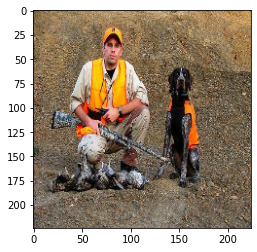

In [30]:
aa = next(iter(ds_train_no_aug))
plt.imshow(aa[0][0])

### (2) Base Augmentation만 적용한 모델

In [31]:
resnet50_base_aug.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.SGD(lr=0.01),
                          metrics=['accuracy'])

history_resnet50_base_aug = resnet50_base_aug.fit(ds_train_base_aug,
                                                  steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
                                                  validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
                                                  epochs=EPOCH,
                                                  validation_data=ds_test_base_aug,
                                                  verbose=1,
                                                  use_multiprocessing=True)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 158s 202ms/step - loss: 2.2714 - accuracy: 0.4267 - val_loss: 3.3055 - val_accuracy: 0.2302
Epoch 2/20
750/750 [==============================] - 150s 200ms/step - loss: 0.9350 - accuracy: 0.7311 - val_loss: 1.6707 - val_accuracy: 0.5380
Epoch 3/20
750/750 [==============================] - 150s 200ms/step - loss: 0.4953 - accuracy: 0.8656 - val_loss: 1.0553 - val_accuracy: 0.6876
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.2671 - accuracy: 0.9363 - val_loss: 0.9677 - val_accuracy: 0.7243
Epoch 5/20
750/750 [==============================] - 150s 200ms/step - loss: 0.1459 - accuracy: 0.9732 - val_loss: 1.0815 - val_accuracy: 0.6999
Epoch 6/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0871 - accuracy: 0.9865 - val_loss: 0.9807 - val_accuracy: 0.7302
Epoch 7/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0517 - accuracy: 0.9933 - val_loss: 1.0019 -

### (3) CutMix Augmentation을 적용한 모델

In [32]:
resnet50_cutmix_aug.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                          metrics=['accuracy'])

In [33]:
history_resnet50_cutmix_aug = resnet50_cutmix_aug.fit(ds_train_cutmix_aug,
                                                  steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
                                                  validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
                                                  epochs=EPOCH,
                                                  validation_data=ds_test_cutmix_aug,
                                                  verbose=1,
                                                  use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 160s 203ms/step - loss: 3.8139 - accuracy: 0.2163 - val_loss: 3.2050 - val_accuracy: 0.2208
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 2.9377 - accuracy: 0.4341 - val_loss: 1.4800 - val_accuracy: 0.5963
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 2.6297 - accuracy: 0.5341 - val_loss: 1.2899 - val_accuracy: 0.6580
Epoch 4/20
750/750 [==============================] - 151s 202ms/step - loss: 2.4090 - accuracy: 0.6105 - val_loss: 1.3213 - val_accuracy: 0.6437
Epoch 5/20
750/750 [==============================] - 151s 202ms/step - loss: 2.2603 - accuracy: 0.6444 - val_loss: 1.1196 - val_accuracy: 0.6925
Epoch 6/20
750/750 [==============================] - 151s 202ms/step - loss: 2.1517 - accuracy: 0.6927 - val_loss: 1.1985 - val_accuracy: 0.6698
Epoch 7/20
750/750 [==============================] - 151s 202ms/step - loss: 2.0230 - accuracy: 0.7293 - val_loss: 1.2256 -

### (4) Mixup Augmentation을 적용한 모델

In [34]:
resnet50_mixup_aug.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                          metrics=['accuracy'])

In [35]:
history_resnet50_mixup_aug = resnet50_mixup_aug.fit(ds_train_mixup_aug,
                                                  steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
                                                  validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
                                                  epochs=EPOCH,
                                                  validation_data=ds_test_mixup_aug,
                                                  verbose=1,
                                                  use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 162s 203ms/step - loss: 3.7189 - accuracy: 0.2387 - val_loss: 4.2228 - val_accuracy: 0.0866
Epoch 2/20
750/750 [==============================] - 152s 202ms/step - loss: 2.8560 - accuracy: 0.4800 - val_loss: 1.4478 - val_accuracy: 0.5920
Epoch 3/20
750/750 [==============================] - 152s 202ms/step - loss: 2.5845 - accuracy: 0.5808 - val_loss: 1.2675 - val_accuracy: 0.6395
Epoch 4/20
750/750 [==============================] - 152s 203ms/step - loss: 2.3723 - accuracy: 0.6626 - val_loss: 1.4960 - val_accuracy: 0.5953
Epoch 5/20
750/750 [==============================] - 152s 202ms/step - loss: 2.2673 - accuracy: 0.7082 - val_loss: 1.2834 - val_accuracy: 0.6419
Epoch 6/20
750/750 [==============================] - 152s 202ms/step - loss: 2.1700 - accuracy: 0.7398 - val_loss: 1.4443 - val_accuracy: 0.6153
Epoch 7/20
750/750 [==============================] - 152s 202ms/step - loss: 2.0689 - accuracy: 0.7803 - val_loss: 1.3442 -

## 4. 훈련과정 시각화하기
---

* Augementation을 적용하지 않은 모델
* Base Augmentation을 적용한 모델

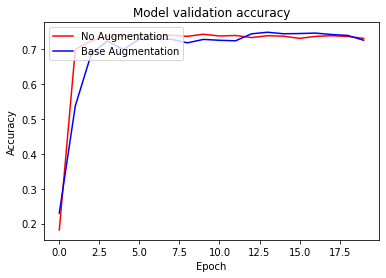

In [36]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Base Augmentation'], loc='upper left')
plt.show()

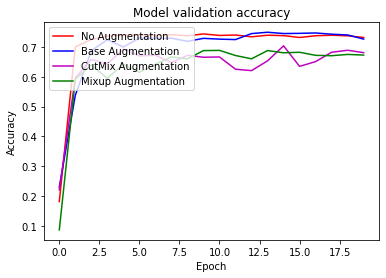

In [37]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Base Augmentation', 'CutMix Augmentation', 'Mixup Augmentation'], loc='upper left')
plt.show()

## 5. Augmentation에 의한 모델 성능비교
---
* No Augmentation
* Base Augmentation
* Base + CutMix Augmentation
* Base + Mixup Augmentatino

위 4가지 데이터셋에 대해 훈련된 ResNet50 Classifier로 견종 분류의 정확도 성능을 비교해보았습니다.

* 일단 EPOCH = 20으로 훈련시켰을 때는 No Augmentation, Base Augmentation, CutMix Augmentation, Mixup Augmentation순으로 높은 accuracy를 보였습니다.

* CutMix Augmentation 데이터셋을 사용했을 때, 에포크에 따른 accuracy가 감소했다 증가하는 등 변동이 있었습니다.


## 6. 회고
---
* 이번노드도 error때문에 2시간 넘게 고민했습니다. 해결하고 보니 단순히 train데이터셋의 이름을 잘못 넣어준 것 뿐이었습니다. 앞으로 코딩을 할 때 변수명이 많아지는데 꼼꼼하게 잘 정리해야겠다고 느꼈습니다. 
* 원래 Augmentation을 해서 데이터셋의 크기를 늘릴수록 성능이 잘 나올 것이라고 예상했지만, Augmentation을 하지 않은 데이터셋으로 실험한 모델의 성능이 가장 좋게 나왔습니다. 주어진 컴퓨터로 EPOCH=20으로 학습시킬 때 3시간 이상 걸린 것 같습니다. 아무래도 더 큰 크기의 데이터셋과 더 큰 에포크로 실험해본다면 다른 결과가 나올 수도 있을 것 같습니다. 


